# Project 3 - Web APIs and NLP Classification

## Part 3: Modelling & Conclusion
* import from previous notebook using pickle

In [1]:
# Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from nltk.tokenize import RegexpTokenizer
from nltk import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, plot_roc_curve, roc_auc_score, recall_score, precision_score, f1_score

pd.set_option("max_columns", None)
pd.set_option("max_rows", None)
pd.set_option('max_colwidth', 200)

In [2]:
df_combined = pd.read_pickle("./data/df_combined.pkl")

In [3]:
df_combined.shape

(3750, 18)

In [4]:
df_combined.head()

,title,selftext,subreddit,alltext,title_tokens,selftext_tokens,alltext_tokens,cleaned_title,cleaned_selftext,cleaned_alltext,title_length,selftext_length,alltext_length,title_count,selftext_count,alltext_count,alltext_lem,alltext_pstem
0,Question: What is ether miners plan post-merge?,"No date is confirmed yet for the merge, but I'm curious what miners are planning to do when that happens. Do they move to ETC, slowly scale down, or just ignore the move altogether?",EtherMining,question what is ether miners plan postmerge no date is confirmed yet for the merge but im curious what miners are planning to do when that happens do they move to etc slowly scale down or just ig...,"[question, what, is, ether, miners, plan, post, merge]","[no, date, is, confirmed, yet, for, the, merge, but, i, m, curious, what, miners, are, planning, to, do, when, that, happens, do, they, move, to, etc, slowly, scale, down, or, just, ignore, the, m...","[question, what, is, ether, miners, plan, postmerge, no, date, is, confirmed, yet, for, the, merge, but, im, curious, what, miners, are, planning, to, do, when, that, happens, do, they, move, to, ...","[question, ether, miners, plan, post, merge]","[date, confirmed, yet, merge, curious, miners, planning, happens, move, etc, slowly, scale, ignore, move, altogether]","[question, ether, miners, plan, postmerge, date, confirmed, yet, merge, im, curious, miners, planning, happens, move, etc, slowly, scale, ignore, move, altogether]",47,181,220,7,34,41,"[question, what, is, ether, miner, plan, postmerge, no, date, is, confirmed, yet, for, the, merge, but, im, curious, what, miner, are, planning, to, do, when, that, happens, do, they, move, to, et...","[question, what, is, ether, miner, plan, postmerg, no, date, is, confirm, yet, for, the, merg, but, im, curiou, what, miner, are, plan, to, do, when, that, happen, do, they, move, to, etc, slowli,..."
1,WTS:Ipollo V1mini 300Mh/240watt for ETH brand new stock,,EtherMining,wtsipollo v1mini 300mh240watt for eth brand new stock,"[wts, ipollo, v1mini, 300mh, 240watt, for, eth, brand, new, stock]",[],"[wtsipollo, v1mini, 300mh240watt, for, eth, brand, new, stock]","[wts, ipollo, v1mini, 300mh, 240watt, eth, brand, new, stock]",[],"[wtsipollo, v1mini, 300mh240watt, eth, brand, new, stock]",55,0,53,8,0,8,"[wtsipollo, v1mini, 300mh240watt, for, eth, brand, new, stock]","[wtsipollo, v1mini, 300mh240watt, for, eth, brand, new, stock]"
2,"I dont know why miner getting offline automatically, why this gape in hivos graph",,EtherMining,i dont know why miner getting offline automatically why this gape in hivos graph,"[i, dont, know, why, miner, getting, offline, automatically, why, this, gape, in, hivos, graph]",[],"[i, dont, know, why, miner, getting, offline, automatically, why, this, gape, in, hivos, graph]","[dont, know, miner, getting, offline, automatically, gape, hivos, graph]",[],"[dont, know, miner, getting, offline, automatically, gape, hivos, graph]",81,0,80,14,0,14,"[i, dont, know, why, miner, getting, offline, automatically, why, this, gape, in, hivos, graph]","[i, dont, know, whi, miner, get, offlin, automat, whi, thi, gape, in, hivo, graph]"
3,Miner getting offline,"I dont know why miner getting offline automatically, why this gape in hivos graph",EtherMining,miner getting offline i dont know why miner getting offline automatically why this gape in hivos graph,"[miner, getting, offline]","[i, dont, know, why, miner, getting, offline, automatically, why, this, gape, in, hivos, graph]","[miner, getting, offline, i, dont, know, why, miner, getting, offline, automatically, why, this, gape, in, hivos, graph]","[miner, getting, offline]","[dont, know, miner, getting, offline, automatically, gape, hivos, graph]","[miner, getting, offline, dont, know, miner, getting, offline, automatically, gape, hivos, graph]",21,81,102,3,14,17,"[miner, getting, offline, i, dont, know, why, miner, getting, offline, automatically, why, this, gape, in, hivos, graph]","[miner, get, offlin,

In [5]:
#checking for data imbalance
df_combined['subreddit'].value_counts()

EtherMining       1875
CryptoCurrency    1875
Name: subreddit, dtype: int64

we have a balanced dataset from our valuecounts of each subreddit

In [6]:
#Convert target feature column to numerical values
df_combined['subreddit']= df_combined['subreddit'].map({'EtherMining': 0, 'CryptoCurrency': 1})

In [7]:
#adding additional stopwords derived from EDA earlier
add_stop = ['crypto', 'mining', 'cryptocurrency', 'ethermining', 'ampx200b']
stoplist = stopwords.words('english') + add_stop

### Defining X & y variables and Train test split

In [8]:
#Define X, y and perform Train test split
X = df_combined['alltext']
y = df_combined['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, random_state=42)

In [9]:
print('Training Shape:', X_train.shape)
print('Testing Shape:', X_test.shape)

Training Shape: (2812,)
Testing Shape: (938,)


### Baseline accuracy

In [10]:
#baseline accuracy
y_test.value_counts(normalize = True)

0    0.5
1    0.5
Name: subreddit, dtype: float64

### Setting up pipelines for Models

In [11]:
#CountVectorizer + Random Forest   
pipe_cvec_rf = Pipeline([('cvec', CountVectorizer()),('rf', RandomForestClassifier())])

#TfidfVectorizer + Random Forest       
pipe_tfidf_rf = Pipeline([('tfidf', TfidfVectorizer()),('rf', RandomForestClassifier())])

#CountVectorizer + LogisticRegression
pipe_cvec_logreg = Pipeline([('cvec', CountVectorizer()),('logreg', LogisticRegression())])

#TfidfVectorizer + LogisticRegression
pipe_tfidf_logreg = Pipeline([('tfidf', TfidfVectorizer()),('logreg', LogisticRegression())])

#CountVectorizer + Multinomial Naive Bayes
pipe_cvec_nb = Pipeline([('cvec', CountVectorizer()), ('nb', MultinomialNB())])

#TfidfVectorizer + Multinomial Naive Bayes
pipe_tfidf_nb = Pipeline([('tfidf', TfidfVectorizer()),('nb', MultinomialNB())])

### Gridsearch Parameters

In [12]:
params_cvec_rf = {
    'cvec__max_features' : [1000, 2000, 5000],
    'cvec__stop_words': [stoplist, None],
    'cvec__ngram_range': [(1,1), (1,2)],
    'rf__max_depth' : [1, 3, 5],
    'rf__n_estimators': [50, 200],
    'rf__max_features': [None, 3, 4]
}

params_tfidf_rf = {
    'tfidf__max_features' : [1000, 2000, 5000],
    'tfidf__stop_words': [stoplist, None],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'rf__max_depth' : [1, 3, 5],
    'rf__n_estimators': [50, 200],
    'rf__max_features': [None, 3, 4]
}


params_cvec_logreg = {
    'cvec__max_features' : [1000, 2000, 5000],
    'cvec__stop_words': [stoplist, None],
    'cvec__ngram_range': [(1,1), (1,2)],
    'logreg__penalty': ['l1','l2'],
    'logreg__C': [100, 10, 1.0, 0.1, 0.01],
    'logreg__solver': ['liblinear']
}

params_tfidf_logreg = {
    'tfidf__max_features' : [1000, 2000, 5000],
    'tfidf__stop_words': [stoplist, None],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'logreg__penalty': ['l1','l2'],
    'logreg__C': [100, 10, 1.0, 0.1, 0.01],
    'logreg__solver': ['liblinear']
}

params_cvec_nb = {
    'cvec__max_features' : [1000, 2000, 5000],
    'cvec__stop_words': [stoplist, None],
    'cvec__ngram_range': [(1,1), (1,2)],
    'cvec__min_df': [2, 3], # remove terms that appear in less than n documents
    'cvec__max_df': [.85, .9, .95], # remove frequent terms in n% of documents
}


params_tfidf_nb = {
    'tfidf__max_features' : [1000, 2000, 5000],
    'tfidf__stop_words': [stoplist, None],
    'tfidf__ngram_range': [(1,1), (1,2)],
    'tfidf__min_df': [2, 3],
    'tfidf__max_df': [0.8, 0.9]
}


#### Functions to run each model
As we are going to run GridSearch for the 6 different models (RandomForest-CountVectorizer, RandomForest - TfidVectorizer, MultinomialNB - CountVectorizer, MultinomialNB - TfidVectorizer , LogisticRegression - CountVectorizer and LogisticRegression - TfidVectorizer), let us create a function

In [13]:
#storing results in a dictionary for dataframe display later
results = {}

In [14]:
#Define function to run Pipeline + GridsearchCV
from sklearn.metrics import ConfusionMatrixDisplay


def run_model(pipeline, params, model_name = ''):

    # Instantiate GridsearchCV
    gs = GridSearchCV(pipeline, params, cv = 3, n_jobs = -1)
    # Fit the Gridsearch to Training data
    gs.fit(X_train, y_train)
    # Print the best score found on training data
    print('Best Score:', gs.best_score_)
    # Print the best parameters found on training data
    print('Best Parameters:', gs.best_params_)
    # Use the best estimator that gave the highest score
    gs_model = gs.best_estimator_
    #Score model on Training data
    train_score = gs_model.score(X_train,y_train)
    print('Score on Training Data:', gs_model.score(X_train, y_train))
    # Score model on Testing data
    test_score = gs_model.score(X_test, y_test)
    print('Score on Testing Data:', gs_model.score(X_test, y_test))
    
    # Generalization difference
    gen_diff = round((1 - test_score/train_score) * 100,4)
    print(f'Generalization Difference: {gen_diff}%')

    # Get predictions
    y_pred = gs_model.predict(X_test)
    
    # Calculate ROC_AUC score
    y_proba = gs.predict_proba(X_test)
    auc = round(roc_auc_score(y_test, y_proba[:,1]),4)

    # Confusion Matrix
    cm = confusion_matrix(y_test,y_pred)

    # Plot Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap='Blues')
    plt.show()


    # Save confusion matrix values
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    # Print the different metrics
    # Append metrics and scores to the dictionary
    accuracy = accuracy_score(y_test, y_pred) #Accuracy
    print('Accuracy on test data:', accuracy)
    precision = tp / (tp + fp) #Precision
    print('Precision:', precision)
    recall = tp / (tp + fn) #Sensitivity, Recall
    print('Recall:', recall)
    f1_score = 2 * (precision * recall) / (precision + recall) #F1
    print('F1:', f1_score)
    
    # 'Append' accuracy scores to 'results' dictinoary
    results[model_name] = [train_score, test_score, gen_diff, f1_score, auc]
    
    

## Random Forest

The random forest is a classification algorithm consisting of many decisions trees. It uses bagging and feature randomness when building each individual tree to try to create an uncorrelated forest of trees whose prediction by committee is more accurate than that of any individual tree.

We will run the random forest model with gridsearch across the parameters above using both vectorization methods.

### RandomForest + CountVect

Best Score: 0.8236129157535997
Best Parameters: {'cvec__max_features': 1000, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'an

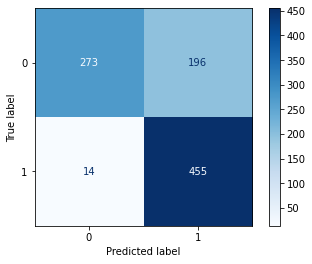

Accuracy on test data: 0.7761194029850746
Precision: 0.6989247311827957
Recall: 0.9701492537313433
F1: 0.8125


In [15]:
run_model(pipe_cvec_rf, params_cvec_rf, model_name = 'cvec_rf')

### RandomForest + TFIDF

Best Score: 0.8069035065562566
Best Parameters: {'rf__max_depth': 5, 'rf__max_features': 3, 'rf__n_estimators': 200, 'tfidf__max_features': 2000, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'th

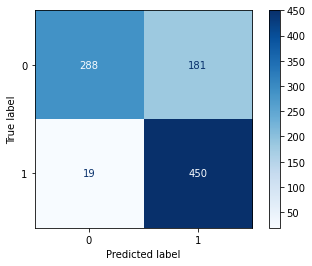

Accuracy on test data: 0.7867803837953091
Precision: 0.7131537242472267
Recall: 0.9594882729211087
F1: 0.8181818181818181


In [16]:
run_model(pipe_tfidf_rf, params_tfidf_rf, model_name = 'tfidf_rf')

From the above confusion matrix, we note that the random forest model does not perform too well and predicts too many false positives. This is reflective in its precision score.

### LogisticRegression + CountVect

/Users/soz/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/soz/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


Best Score: 0.8741059908568151
Best Parameters: {'cvec__max_features': 5000, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None, 'logreg__C': 1.0, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear'}
Score on Training Data: 0.972972972972973
Score on Testing Data: 0.8614072494669509
Generalization Difference: 11.4665%


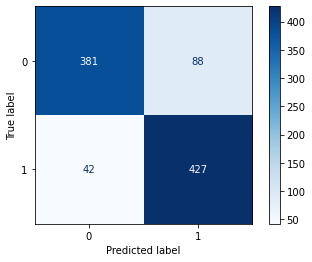

Accuracy on test data: 0.8614072494669509
Precision: 0.829126213592233
Recall: 0.9104477611940298
F1: 0.8678861788617886


In [17]:
run_model(pipe_cvec_logreg, params_cvec_logreg, model_name = 'cvec_logreg')

### LogisticRegression + TFIDF

Best Score: 0.8765939323052369
Best Parameters: {'logreg__C': 1.0, 'logreg__penalty': 'l2', 'logreg__solver': 'liblinear', 'tfidf__max_features': 5000, 'tfidf__ngram_range': (1, 1), 'tfidf__stop_words': None}
Score on Training Data: 0.9402560455192034
Score on Testing Data: 0.8848614072494669
Generalization Difference: 5.8914%


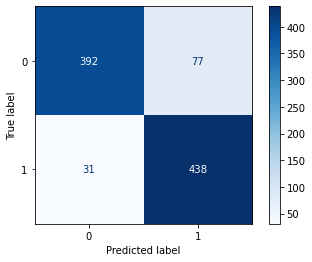

Accuracy on test data: 0.8848614072494669
Precision: 0.8504854368932039
Recall: 0.9339019189765458
F1: 0.8902439024390244


In [18]:
run_model(pipe_tfidf_logreg, params_tfidf_logreg, model_name = 'tfidf_logreg')

### Naive Bayes model + CountVect

Best Score: 0.8748205155045022
Best Parameters: {'cvec__max_df': 0.85, 'cvec__max_features': 5000, 'cvec__min_df': 2, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None}
Score on Training Data: 0.9086059743954481
Score on Testing Data: 0.8859275053304904
Generalization Difference: 2.496%


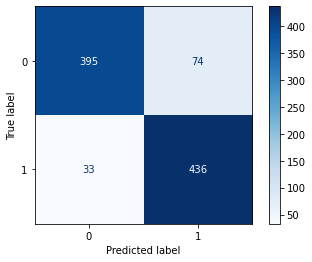

Accuracy on test data: 0.8859275053304904
Precision: 0.8549019607843137
Recall: 0.929637526652452
F1: 0.8907048008171603


In [19]:
run_model(pipe_cvec_nb, params_cvec_nb, model_name = 'cvec_nb')

### Naive Bayes model + TFIDF

Best Score: 0.8637943079237141
Best Parameters: {'tfidf__max_df': 0.8, 'tfidf__max_features': 5000, 'tfidf__min_df': 2, 'tfidf__ngram_range': (1, 2), 'tfidf__stop_words': None}
Score on Training Data: 0.916429587482219
Score on Testing Data: 0.8827292110874201
Generalization Difference: 3.6774%


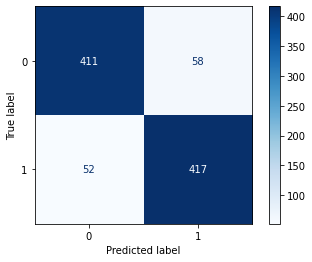

Accuracy on test data: 0.8827292110874201
Precision: 0.8778947368421053
Recall: 0.8891257995735607
F1: 0.8834745762711864


In [20]:
run_model(pipe_tfidf_nb, params_tfidf_nb, model_name = 'tfidf_nb')

In [21]:
results

{'cvec_rf': [0.8232574679943101, 0.7761194029850746, 5.7258, 0.8125, 0.9096],
 'tfidf_rf': [0.8317923186344239,
  0.7867803837953091,
  5.4114,
  0.8181818181818181,
  0.9018],
 'cvec_logreg': [0.972972972972973,
  0.8614072494669509,
  11.4665,
  0.8678861788617886,
  0.9414],
 'tfidf_logreg': [0.9402560455192034,
  0.8848614072494669,
  5.8914,
  0.8902439024390244,
  0.9544],
 'cvec_nb': [0.9086059743954481,
  0.8859275053304904,
  2.496,
  0.8907048008171603,
  0.9427],
 'tfidf_nb': [0.916429587482219,
  0.8827292110874201,
  3.6774,
  0.8834745762711864,
  0.9524]}

In [22]:
# Convert results dictionary into Dataframe for analysis
results_df = pd.DataFrame.from_dict(results, orient='index', columns=['train_score', 'test_score', 'generalisation',
                                                                      'f1_score', 'roc_auc_score'])
results_df

,train_score,test_score,generalisation,f1_score,roc_auc_score
cvec_rf,0.823257,0.776119,5.7258,0.812500,0.9096
tfidf_rf,0.831792,0.786780,5.4114,0.818182,0.9018
cvec_logreg,0.972973,0.861407,11.4665,0.867886,0.9414
tfidf_logreg,0.940256,0.884861,5.8914,0.890244,0.9544
cvec_nb,0.908606,0.885928,2.4960,0.890705,0.9427
tfidf_nb,0.916430,0.882729,3.6774,0.883475,0.9524


In [33]:
print(results_df.to_markdown(index=False))

|   train_score |   test_score |   generalisation |   f1_score |   roc_auc_score |
|--------------:|-------------:|-----------------:|-----------:|----------------:|
|      0.823257 |     0.776119 |           5.7258 |   0.8125   |          0.9096 |
|      0.831792 |     0.78678  |           5.4114 |   0.818182 |          0.9018 |
|      0.972973 |     0.861407 |          11.4665 |   0.867886 |          0.9414 |
|      0.940256 |     0.884861 |           5.8914 |   0.890244 |          0.9544 |
|      0.908606 |     0.885928 |           2.496  |   0.890705 |          0.9427 |
|      0.91643  |     0.882729 |           3.6774 |   0.883475 |          0.9524 |


# AUC - ROC Curve

In [23]:
#setting up models for AUC-ROC curve
grid_log_tfidf = GridSearchCV(pipe_tfidf_logreg,
                              param_grid=params_tfidf_logreg,
                              cv=3)

grid_log_cvec = GridSearchCV(pipe_cvec_logreg,
                             param_grid=params_cvec_logreg,
                              cv=3)

grid_rf_cvec = GridSearchCV(pipe_cvec_rf,
                            param_grid=params_cvec_rf,
                            cv=3)

grid_rf_tfidf = GridSearchCV(pipe_tfidf_rf,
                            param_grid=params_tfidf_rf,
                            cv=3)

grid_nb_tfidf = GridSearchCV(pipe_tfidf_nb,
                            param_grid=params_tfidf_nb,
                            cv=3)

grid_nb_cvec = GridSearchCV(pipe_cvec_nb,
                           param_grid=params_cvec_nb,
                           cv=3)

/Users/soz/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
/Users/soz/opt/anaconda3/lib/python3.9/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


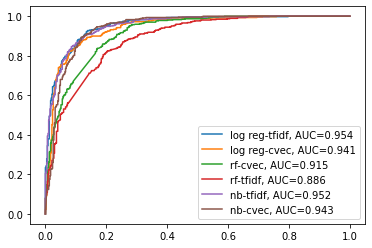

In [24]:
#set up plotting area
plt.figure(0).clf()

#fit log tfidf model and plot ROC curve
grid_log_tfidf.fit(X_train, y_train)
y_pred = grid_log_tfidf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 3)
plt.plot(fpr,tpr,label="log reg-tfidf, AUC="+str(auc))

#fit log cvec model and plot ROC curve
grid_log_cvec.fit(X_train, y_train)
y_pred = grid_log_cvec.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 3)
plt.plot(fpr,tpr,label="log reg-cvec, AUC="+str(auc))

#fit random forest cvec model and plot ROC curve
grid_rf_cvec.fit(X_train, y_train)
y_pred = grid_rf_cvec.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 3)
plt.plot(fpr,tpr,label="rf-cvec, AUC="+str(auc))

#fit random forest tfidf and plot ROC curve
grid_rf_tfidf.fit(X_train, y_train)
y_pred = grid_rf_tfidf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 3)
plt.plot(fpr,tpr,label="rf-tfidf, AUC="+str(auc))

#fit naive bayes tfidf and plot ROC curve
grid_nb_tfidf.fit(X_train, y_train)
y_pred = grid_nb_tfidf.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 3)
plt.plot(fpr,tpr,label="nb-tfidf, AUC="+str(auc))

#fit naive bayes cvec and plot ROC curve
grid_nb_cvec.fit(X_train, y_train)
y_pred = grid_nb_cvec.predict_proba(X_test)[:, 1]
fpr, tpr, _ = metrics.roc_curve(y_test, y_pred)
auc = round(metrics.roc_auc_score(y_test, y_pred), 3)
plt.plot(fpr,tpr,label="nb-cvec, AUC="+str(auc))

#add legend
plt.legend();

In [25]:
grid_nb_cvec.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.85, 0.9, 0.95],
                         'cvec__max_features': [1000, 2000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "i

In [26]:
preds = grid_nb_cvec.predict(X_test)

In [27]:
pred_df = pd.DataFrame(data=X_test)
pred_df['actual'] = y_test
pred_df['predicted'] = preds
misclassified_df = pred_df[pred_df['actual'] != pred_df['predicted']]

In [29]:
#some examples of misclassified text
misclassified_df.head(5)

,alltext,actual,predicted
700,862 for a new 3090 this man must be very desperate,0,1
2496,saw shping a while ago and it regularly does 200 300 350 upward movements it seems that it is about to happen again,1,0
1997,oh brother,0,1
1179,saw this and thought id share here as an fyi,0,1
1566,what is your way of glossing up crypto mining so for me i would always want to say im sophisticated and as a 16yearold it makes me feel good about it i would typically say that i assist in securin...,0,1


# Conclusion & Recommendations

Classification models, unlike regression models have multiple metrics which results may be based on. 
Accuracy is used when the True Positives and True negatives are more important while F1-score is used when the False Negatives and False Positives are crucial. F1 score is usually handy for imbalanced datasets (as its calculated based on Precision and Recall). Lastly, for the area under curve of a ROC curve, it measures the usefulness of a test in general, where a greater area means a more useful test, the areas under ROC curves are used to compare the usefulness of tests. AUC metric measure performance for the classification problem at various threshold settings.

As we are not currently solving any specific problem statements and that we are dealing with a balanced dataset, the following considerations may be used in determining the "best" model.

* Highest accuracy score
* Best generalization score


Form the results above, the most suited model for our specific classification task would be the Multinomial Naive Bayes with CountVectorizer model. It has the highest accuracy score and generalizes the best. It is worth noting
that though we have chosen the MultinomialNB model to be the best performer, it is nicknamed “naive” due to the fact that the model treats all words equally. It ignores grammar rules and common phrases.

However, there are definitely still things to consider especially in the event of a business setting: 
* AUC-ROC curve may not be the only indicator of finding the 'best' model when compared against other models.
* Different functions may look at different metrics prior to deciding on which model to implement to production. (e.g Marketing/sale may focus on recall , whilst other functions may want to focus on precision etc)


# Recommendations:
* Better data cleaning via reggex to remove wallet addresses whilst retaining the graphics card specific numbers for example which are prevelant in ethermining subreddit would be good. As well as maybe having a spam filter to remove spam post which appear often in both subreddits. 
* We’re dealing with a balanced dataset. For imbalance dataset, class weights and over sampling techniques such as SMOTE may be implemented. F1 score could also come in handy for imbalanced datasets (as its calculated based on Precision and Recall).
* May consider testing out other models which may perform better for such a task specific to this project.